In [1]:
import numpy as np
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization_sg import *

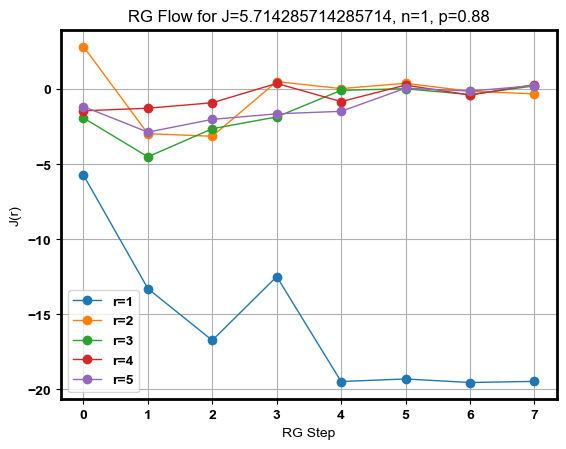

CPU times: user 27.3 s, sys: 78.7 ms, total: 27.4 s
Wall time: 27.5 s


In [16]:
%%time
# RG flow

J = 1/0.175
n = 1
p = .88
max_k = 5000
num_r_to_plot = 5

all_Js = generate_rg_flow(J0=J, n=n, p=p, max_k=max_k, num_steps=7, seed=42)

# Plot J vs RG step for first num_r_to_plot r
fig = plt.figure()
steps = range(len(all_Js))
for r_idx in range(min(num_r_to_plot, max_k)):
    Js_step = [all_Js[s][r_idx] for s in steps]
    plt.plot(steps, [float(j) for j in Js_step], label=f'r={r_idx+1}', marker='o')
plt.xlabel('RG Step')
plt.ylabel('J(r)')
plt.title(f'RG Flow for J={J}, n={n}, p={p}')
plt.xticks(steps)
plt.legend()
plt.grid(True)
plt.show()

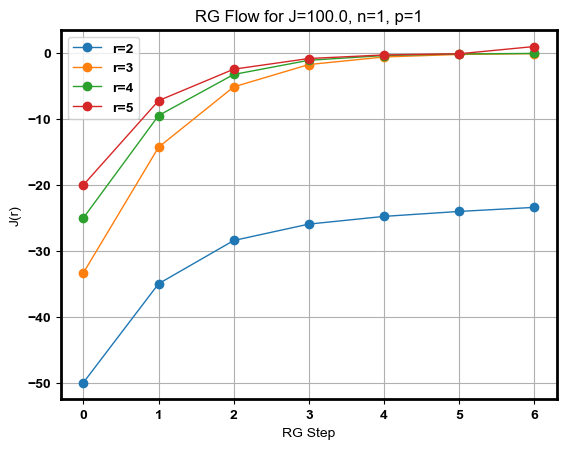

In [15]:
# Plot J vs RG step for first num_r_to_plot r
fig = plt.figure()
steps = range(7)

for r_idx in range(1, 5):
    Js_step = [all_Js[s][r_idx] for s in steps]
    plt.plot(steps, [float(j) for j in Js_step], label=f'r={r_idx+1}', marker='o')
plt.xlabel('RG Step')
plt.ylabel('J(r)')
plt.title(f'RG Flow for J={J}, n={n}, p={p}')
plt.xticks(steps)
plt.legend()
plt.grid(True)
#plt.savefig(f'J{J}n{n}p{p}.png')
plt.show()

## Phase separation lines

## Horizontal line

For n=1, p=0.4: Tc=9.995238664900667
For n=1, p=0.45: Tc=1.3498053865882322
For n=1, p=0.5: Tc=0.8818808157811332
For n=1, p=0.55: Tc=0.01000000476360548
For n=1, p=0.6: Tc=0.01000000476360548


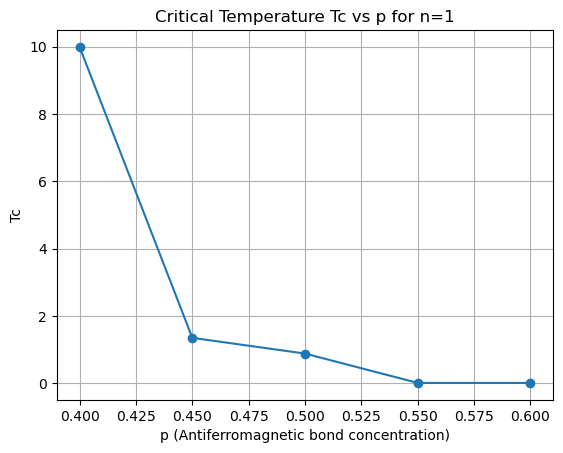

In [3]:
n = 1
p_values = np.linspace(.4, .6, 5)
max_k = 22000
tol = 1e-4

# Compute Tc for each p
filtered_p = []
Tc_values = []
for curr_p in p_values:
    Tc = find_Tc_fixed_p(n, curr_p,
                         max_k=max_k, tol=tol,
                         J_low=0.1, J_high=100.0,
                         skip_steps=3, track_rs=[2,3],
                         seed=42)

    if Tc is None:
        print(f"For n={n}, p={curr_p}: Disorder phase, no Tc found")
    else:
        filtered_p.append(curr_p)
        Tc_values.append(Tc)
        print(f"For n={n}, p={curr_p}: Tc={Tc}")

# Plot results
if filtered_p:
    plt.figure()
    plt.plot(filtered_p, Tc_values, marker='o')
    plt.xlabel('p (Antiferromagnetic bond concentration)')
    plt.ylabel('Tc')
    plt.title(f'Critical Temperature Tc vs p for n={n}')
    plt.grid(True)
    plt.show()
else:
    print("No phase transitions found for any p.")

## Vertical line

In [ ]:
# Define parameters
n = 1  # Fixed power-law exponent
T_values = np.linspace(0.1, 3.4, 5)
max_k = 22000
tol = 1e-4
seed = 42

# Compute pc for each T
filtered_T = []
pc_values = []
for curr_T in T_values:
    pc = find_pc_fixed_T(n, curr_T, max_k=max_k, tol=tol,
                         p_low=0.01, p_high=0.9, seed=seed,
                         max_steps=8)
    if pc is None:
        print(f"For n={n}, T={curr_T}: No critical p found (ferro or disorder assumption violated or undecided)")
    else:
        filtered_T.append(curr_T)
        pc_values.append(pc)
        print(f"For n={n}, T={curr_T}: pc={pc}")

# Plot results
if filtered_T:
    plt.figure()
    plt.plot(filtered_T, pc_values, marker='o')
    plt.xlabel('T')
    plt.ylabel('pc')
    plt.title(f'Critical p (pc) vs T for n={n}')
    plt.grid(True)
    plt.show()
else:
    print("No critical p found for any T.")

# Phase Diagram

In [12]:
Undecided_Phase

[[np.float64(0.52), np.float64(0.01)],
 [np.float64(0.5800000000000001), np.float64(0.01)],
 [np.float64(0.64), np.float64(0.01)],
 [np.float64(0.7), np.float64(0.01)],
 [np.float64(0.8200000000000001), np.float64(0.01)],
 [np.float64(0.88), np.float64(0.01)],
 [np.float64(0.88), np.float64(0.17500000000000002)],
 [np.float64(1.0), np.float64(0.01)]]

100%|██████████| 11/11 [36:52<00:00, 201.16s/it]


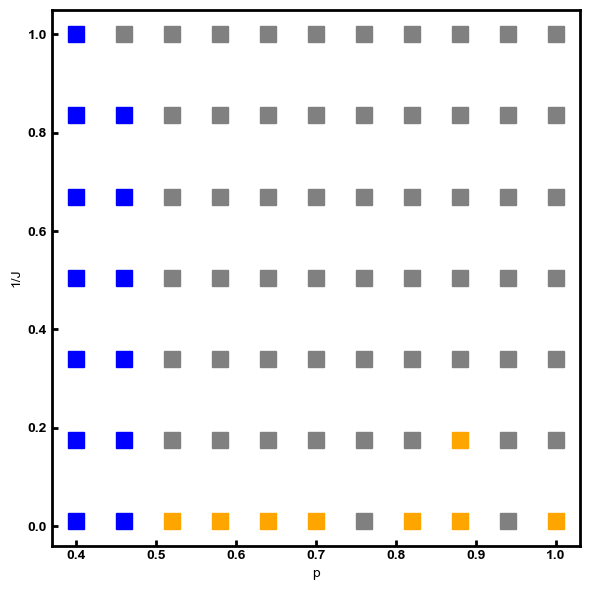

CPU times: user 36min 52s, sys: 826 ms, total: 36min 52s
Wall time: 36min 52s


In [11]:
%%time

n = 1.0  # Fixed n (power-law exponent)
p_values = np.linspace(0.4, 1.0, 11)
inv_J_values = np.linspace(0.01, 1.0, 7)
Disorder_Phase, Ferro_Phase, Undecided_Phase = plot_phase_diagram(
    n, p_values, inv_J_values,
    max_k=50000,
    skip_steps=5,
    track_rs=[2, 3, 4, 5])

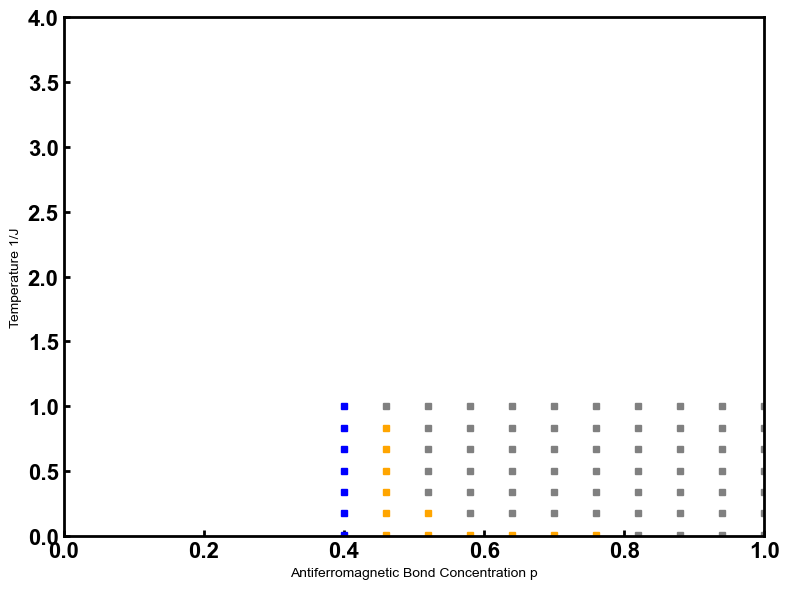

In [9]:
ms = 4

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), dpi=100)
fig.set_facecolor("white")
plt.rc(group="font", family="Arial", weight="bold", size=10)
plt.rc(group="lines", linewidth=1)
plt.rc(group="axes", linewidth=2)
cdic = {"disorder":"gray",
        "ferro":"blue",
        "undecided":"orange"}
if Disorder_Phase: ax.plot(np.array(Disorder_Phase)[:,0], np.array(Disorder_Phase)[:,1], ls="", marker="s", mfc=cdic["disorder"], mec=cdic["disorder"], ms=ms, alpha=1)
if Ferro_Phase: ax.plot(np.array(Ferro_Phase)[:,0], np.array(Ferro_Phase)[:,1], ls="", marker="s", mfc=cdic["ferro"], mec=cdic["ferro"], ms=ms, alpha=1)
if Undecided_Phase: ax.plot(np.array(Undecided_Phase)[:,0], np.array(Undecided_Phase)[:,1], ls="", marker="s", mfc=cdic["undecided"], mec=cdic["undecided"], ms=ms, alpha=1)
ax.set_xlabel("Antiferromagnetic Bond Concentration p")
ax.set_ylabel("Temperature 1/J")
ax.set_xlim(0, 1)
ax.set_ylim(0, 4)

ax.tick_params(axis="both", direction="in", width=2, length=4, labelsize=16)
fig.tight_layout()
plt.savefig('../results/phase_diagram_n1_22000.png')
plt.show()